In [1]:
import json
from PIL import Image, ImageDraw
import numpy as np
import pprint
import random
import os
import shutil
import math
import torch

# Loading and Exploring the Data

In [2]:
# Loads the catalogued products data from S3
# Note: the data was collected and catalogued using Edge Impulse (https://www.edgeimpulse.com/)
! curl https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/raw_image_data.zip --output raw_image_data.zip --silent
! tar -xf ./raw_image_data.zip
! del "raw_image_data.zip"

In [20]:
RAW_DATA_PATH = './raw_image_data/'
LABELS_FILE = './labels.txt'

In [21]:
# Generates a dictionary containing an entry for each object/product

with open(LABELS_FILE, 'r') as labelfile:
    labels = [label.replace('\n', '') for label in labelfile.readlines()]
    LABELS_DICT = {}
    for idx, label in enumerate(labels):
        random_colour = tuple(np.random.choice(range(256), size=3))
        LABELS_DICT[label] = {'id': idx, 'bb_color_rgb': random_colour, 'pictures': {}, 'total_pictures': 0}
        
pprint.pprint(LABELS_DICT)

{'blue_pens': {'bb_color_rgb': (152, 251, 69),
               'id': 4,
               'pictures': {},
               'total_pictures': 0},
 'card_deck': {'bb_color_rgb': (185, 170, 49),
               'id': 3,
               'pictures': {},
               'total_pictures': 0},
 'coke_soda': {'bb_color_rgb': (245, 195, 32),
               'id': 2,
               'pictures': {},
               'total_pictures': 0},
 'guarana_soda': {'bb_color_rgb': (106, 199, 70),
                  'id': 1,
                  'pictures': {},
                  'total_pictures': 0},
 'post_it': {'bb_color_rgb': (65, 121, 60),
             'id': 0,
             'pictures': {},
             'total_pictures': 0}}


In [22]:
AMT_CLASSES = len(LABELS_DICT)
print('Total Number of Classes: {}'.format(AMT_CLASSES))

Total Number of Classes: 5


# Exploring the Raw Data

In [23]:
# Inspecting the dictionary that contains the labels and bounding boxes present in each picture from the raw data
bounding_boxes = json.load(open(RAW_DATA_PATH + 'bounding_boxes.labels'))
print(json.dumps(bounding_boxes, indent=2)[0:300])

{
  "version": 1,
  "type": "bounding-box-labels",
  "boundingBoxes": {
    "unknown.39n097ne.ingestion-645f8b4d4f-p2vmk.jpg": [
      {
        "label": "guarana_soda",
        "x": 120,
        "y": 265,
        "width": 172,
        "height": 207
      },
      {
        "label": "coke_soda",
   


In [24]:
total_pictures = len(bounding_boxes['boundingBoxes'])
print("Total number of pictures: {}".format(total_pictures))

Total number of pictures: 1000


## Analysing an individual picture

In [25]:
random_img_nm = random.choice(list(bounding_boxes['boundingBoxes'].keys()))
random_img_labels = bounding_boxes['boundingBoxes'][random_img_nm]
print("Random image name: {}".format(random_img_nm))
pprint.pprint(random_img_labels)

Random image name: unknown.396mopbs.ingestion-959df9999-dqftq.jpg
[{'height': 148, 'label': 'blue_pens', 'width': 505, 'x': 81, 'y': 331}]


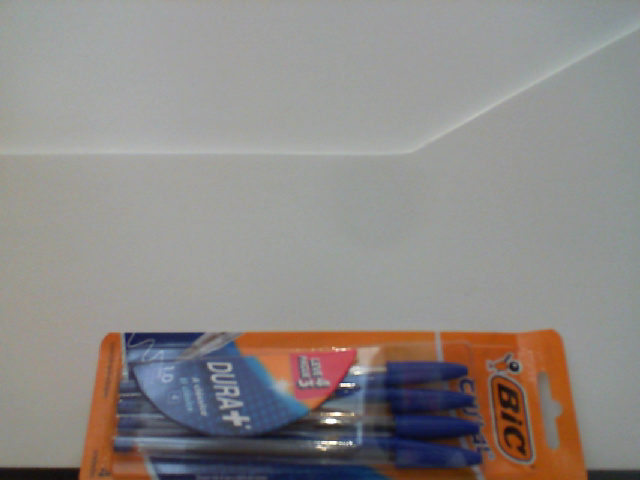

In [26]:
random_img_path = RAW_DATA_PATH + random_img_nm
random_img = Image.open(random_img_path)
random_img

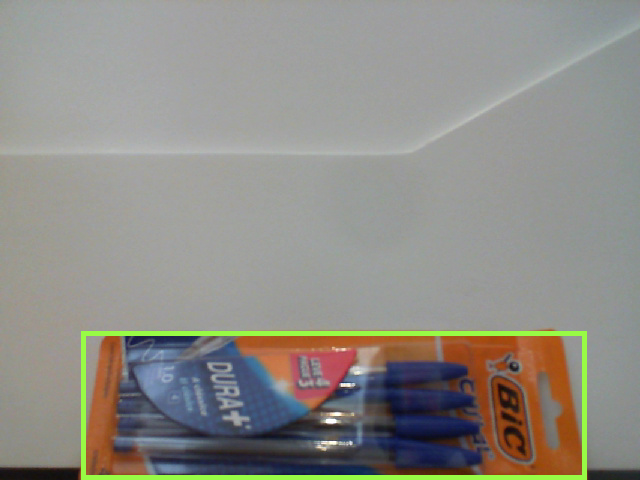

In [27]:
def draw_bounding_boxes(img, img_labels):
  draw = ImageDraw.Draw(img)

  for label in img_labels:
    label_nm = label['label']
    width = float(label['width'])
    height = float(label['height'])

    # top-left (1) and bottom-right (2) coordinates
    x1 = float(label['x'])
    y1 = float(label['y'])
    x2 = float(label['x']) + width
    y2 = float(label['y']) + height

    draw.rectangle(
        (x1, y1, x2, y2),
        outline=LABELS_DICT[label_nm]['bb_color_rgb'], 
        width=5 # line width
    )
    
    return img
  
draw_bounding_boxes(random_img, random_img_labels)

# Preparing the training data

In [11]:
# Traversing the bounding_boxes dictionary to be able to identify more easily what are the pictures in which you can see each label, 
# and what are the positions of each bounding box in those pictures
for img in bounding_boxes["boundingBoxes"]:
  for obj in bounding_boxes["boundingBoxes"][img]:
    LABELS_DICT[obj['label']]['pictures'][RAW_DATA_PATH + img] = \
        {
            'x': obj['x'], 
            'y': obj['y'], 
            'width': obj['width'], 
            'height': obj['height']
         }
    LABELS_DICT[obj['label']]['total_pictures'] += 1

pprint.pprint(LABELS_DICT)

{'blue_pens': {'bb_color_rgb': (227, 26, 252),
               'id': 4,
               'pictures': {'./raw_image_data/unknown.396mohgb.ingestion-959df9999-p6s57.jpg': {'height': 84,
                                                                                                'width': 251,
                                                                                                'x': 258,
                                                                                                'y': 320},
                            './raw_image_data/unknown.396mopbs.ingestion-959df9999-dqftq.jpg': {'height': 148,
                                                                                                'width': 505,
                                                                                                'x': 81,
                                                                                                'y': 331},
                            './raw_image_data/unknown.396mp5f9.

In [12]:
print('Total pictures for each class:')
for label in LABELS_DICT:
  print(label + ', ' + str(LABELS_DICT[label]['total_pictures']))

Total pictures for each class:
post_it, 273
guarana_soda, 283
coke_soda, 276
card_deck, 306
blue_pens, 293


## YOLOv5-specific data preparation
To make use of the YoloV5 network, the data must be organized in the following directory structure:  
> ![image.png](https://i0.wp.com/kikaben.com/wp-content/uploads/2021/04/Screen-Shot-2021-04-25-at-20.54.36.png?resize=201%2C300&ssl=1)  

Reference: https://kikaben.com/yolov5-transfer-learning-dogs-cats/

In [13]:
! mkdir yolov5-transfer-learning
! cd yolov5-transfer-learning

In [14]:
# Creates the folder structure for YOLOv5 training
if not os.path.exists('yolov5-transfer-learning/data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'yolov5-transfer-learning/data/{folder}/{split}')

In [15]:
# Defines a function to split the dataset to train, test and validation sets
def split_dataset(class_name, img_names, train_size, val_size):
  for idx, img_path_and_name in enumerate(img_names):
        # Name that will be given to the labelfile corresponding to each picture
        label_file_name = img_path_and_name.replace('.jpg', '.txt').replace('./raw_image_data', '')
        
        # Split into train, val and test
        if idx < train_size:
            split = 'train'
        elif idx < train_size + val_size:
            split = 'val'
        else:
            split = 'test'
        
        source_img_path = img_path_and_name
        target_img_folder = f'yolov5-transfer-learning/data/images/{split}'
        shutil.copy(source_img_path, target_img_folder)

        img = Image.open(source_img_path)
        img_width, img_height = img.size
        
        target_label_folder = f'yolov5-transfer-learning/data/labels/{split}'

        # Writes a label file for each picture, in the standardized format expected as an input to the YOLOv5 implementation.
        # The format for the contents in each labelfile looks like this:
        # id_class x_center y_center bounding_box_width bounding_box_height 
        
        with(open(target_label_folder + label_file_name, 'w')) as label_file:
          id_class = LABELS_DICT[class_name]['id']
          # Numerical values scale from 0 to 1 relative to the image size
          x_center = float((LABELS_DICT[class_name]['pictures'][img_path_and_name]['x'] + LABELS_DICT[class_name]['pictures'][img_path_and_name]['width']/2.0)/img_width)
          y_center = float((LABELS_DICT[class_name]['pictures'][img_path_and_name]['y'] + LABELS_DICT[class_name]['pictures'][img_path_and_name]['height']/2.0)/img_height)
          bb_width = float(LABELS_DICT[class_name]['pictures'][img_path_and_name]['width']/img_width)
          bb_height = float(LABELS_DICT[class_name]['pictures'][img_path_and_name]['height']/img_height)

          label_file.write(
              str(id_class) + ' ' + str(x_center) + ' ' + str(y_center) + ' ' + str(bb_width) + ' ' + str(bb_height)
          )

In [16]:
TRAIN_PCT = 70

# The absolute train and validation sets size will be different, but its relative sizes to the total number of pictures in each class will be the same,
# and that is defined by the TRAIN_PCT constant. 

print('CLASS\tTRAIN SIZE (amt of pictures)\tVALIDATION SIZE (amt of pictures)')
for label in LABELS_DICT:
  train_size  = math.ceil(LABELS_DICT[label]['total_pictures'] * TRAIN_PCT/100)
  val_size    = LABELS_DICT[label]['total_pictures'] - math.ceil(LABELS_DICT[label]['total_pictures'] * TRAIN_PCT/100)
  img_names   =  list(LABELS_DICT[label]['pictures'].keys())
  
  print('{}\t{}\t{}'.format(label, train_size, val_size))
  split_dataset(
      class_name  = label, 
      img_names = img_names,
      train_size = train_size,
      val_size = val_size
  )
  

post_it 192 81
guarana_soda 199 84
coke_soda 194 82
card_deck 215 91
blue_pens 206 87


# YOLOv5 Transfer Learning Preparation

In [ ]:
# In order to use the original YOLOv5 implementation for transfer learning, we have to clone it from its original repository
! cd ./yolov5-transfer-learning
! git clone https://github.com/ultralytics/yolov5

In [3]:
os.chdir('./yolov5')
! pip install -r requirements.txt coremltools onnx onnx-simplifier onnxruntime openvino-dev tensorflow-cpu tensorflow onnxruntime-gpu
from utils.plots import plot_results
os.chdir('../')

In [18]:
# To have our model trained using YOLOv5, we need to create an specification YAML file that will tell important information on the data
# the file "classes_specs.yaml" will be created for this purpose:
with(open('classes_specs.yaml', 'w')) as f:
  class_names_formatted = "[" + ', '.join(LABELS_DICT.keys()) + "]"
  f.write(
      "# Dataset paths relative to the yolov5 folder\n" + \
      "train: ../yolov5-transfer-learning/data/images/train\n" + \
      "val:   ../yolov5-transfer-learning/data/images/val\n" + \
      "test:  ../yolov5-transfer-learning/data/images/test\n" + \
      "# Number of classes\n" + \
      "nc: " + str(AMT_CLASSES) + "\n" + \
      "# Class names\n" + \
      "names: " + class_names_formatted
  )

# Model Training

The YOLOv5 documentation covers a [detailed explanation](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) on how to train custom models, so we definetely recommend that you check it out!    
By following the documentation, we chose the yolov5s (small) pre-trained model for our experiment, as we want our model inference to be as fast as possible.  
As we want to use transfer learning from the original YOLOv5 to train our custom model, we are freezing the backbone layers of the network, as they contain the image features processing weights used in the original network.  
To verify how many are backbone layers does the yolov5s model have, the zcart\product_recognizer\model\yolov5\models\yolov5s.yaml YAML file can be used as a reference.  
Upon verifying it, we have asserted that it has 10 backbone layers, so we are freezing them all. 

In [ ]:
! python yolov5/train.py --data classes_specs.yaml --weights yolov5s.pt --epochs 200 --batch 16 --freeze 10

# Model Evaluation

The main metrics related to the model's metrics are shown below. 
Other relevant metrics will be available in the **./product_recognizer/metric/s** directory.

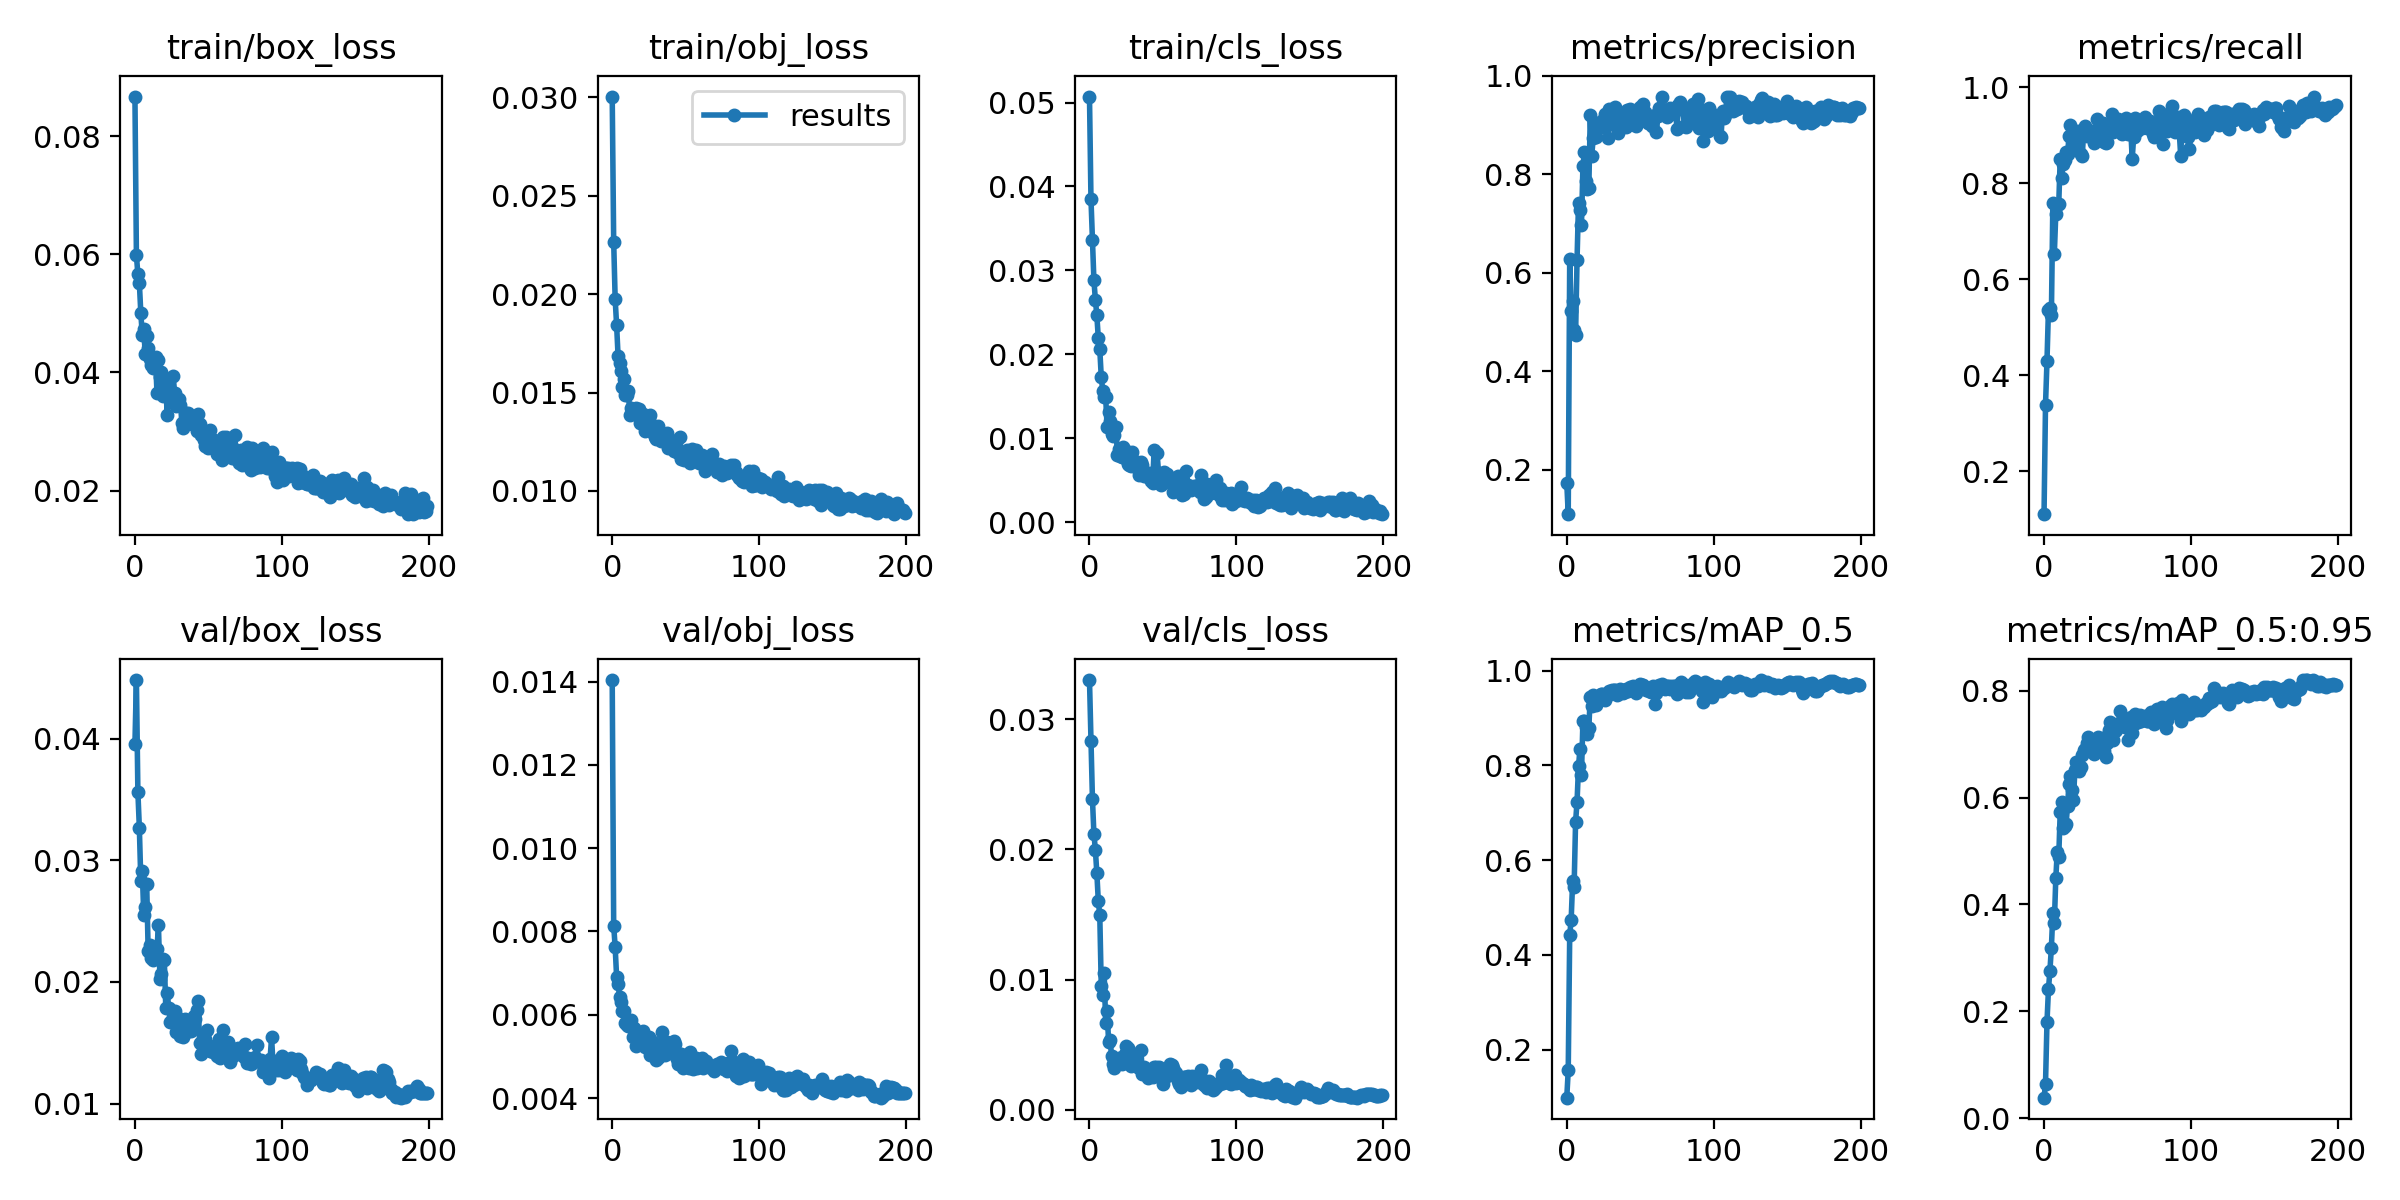

In [4]:
plot_results('./yolov5/runs/train/exp/results.csv') #plots 'results.csv' as 'results.png'
Image.open('./yolov5/runs/train/exp/results.png')

In [ ]:
! mkdir metrics
! xcopy .\yolov5\runs\train\* .\metrics\ /E /H /C /I

# Use the model for inference

Uses the weights from the best training epoch for inference: **best.pt**  
**best.pt** is determined automatically during training in the YoloV5 implementation, based in the best fitness observed on our validation set.  
The "fitness" is defined as a weighted combination of metrics, and its definition can be seen on file [./yolov5/utils/metrics.py](./yolov5/utils/metrics.py)

In [ ]:
! python ./yolov5/detect.py --weights ./yolov5/runs/train/exp/weights/best.pt --source 0 --data ./classes_specs.yaml

# Convert the model for usage with TensorFlow Lite 
Converts the model's best weights from the default pytorch's ".pt" format to a TensorFlow Lite-compatible format (.tflite)

In [ ]:
! python ./yolov5/export.py --weights ./yolov5/runs/train/exp/weights/best.pt --include tflite --data ./classes_specs.yaml

In [ ]:
# File runs\train\exp\weights\best-fp16.tflite was created, storing the tflite weights
! copy .\yolov5\runs\train\exp\weights\best-fp16.tflite .
! ren best-fp16.tflite custom_model.tflite